## Setup ##

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Clustering the Olivetti Faces Dataset ##

The Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each),

In [3]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\G Surya Krishna\scikit_learn_data


In [4]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [5]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

Since the dataset is quite small, we might want to use stratified sampling to ensure that there are the same number of images per person in each set.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits = 1, test_size = 40, random_state = 42)
train_valid_idx , test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits = 1, test_size = 80, random_state = 43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [7]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, let's reduce the dimensionality using PCA by preserving 99% variance.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

For peforming clustering using K-Means. Let's select the optimal number of clusters by plotting silhouette score as the function of clusters

In [12]:
from sklearn.cluster import KMeans

k_range = range(5,150,5)
kmeans_per_k = []

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

Saving figure Silhouette plot


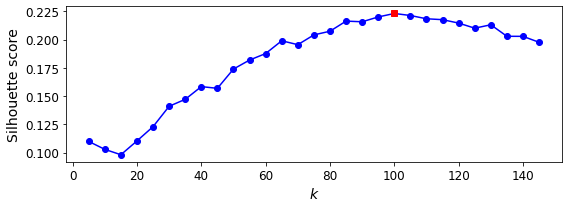

In [15]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_) for model in kmeans_per_k]

best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize = (8,3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize = 14)
plt.ylabel("Silhouette score", fontsize = 14)
plt.plot(best_k, best_score, "rs")

save_fig('Silhouette plot')
plt.show()



In [16]:
best_k

100

Let's how inertia plot looks like

Saving figure intertia plot


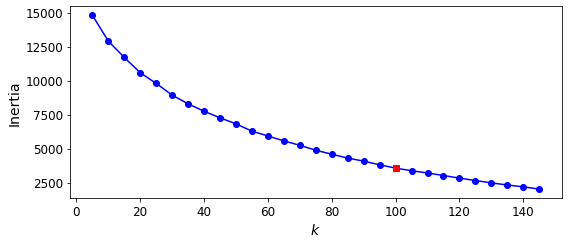

In [17]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize = (8,3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize = 14)
plt.ylabel("Inertia", fontsize = 14)
plt.plot(best_k, best_inertia, "rs")
save_fig("intertia plot")

plt.show()

The optimal number of clusters from inertia is not clear due to absence of elbow. So, let's stick with 100 clusters.

In [19]:
best_model = kmeans_per_k[best_index]

Cluster 0


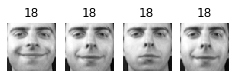

Cluster 1


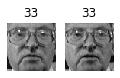

Cluster 2


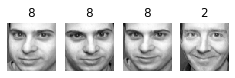

Cluster 3


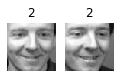

Cluster 4


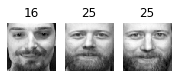

Cluster 5


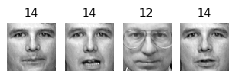

Cluster 6


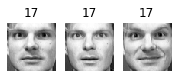

Cluster 7


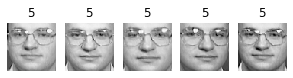

Cluster 8


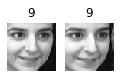

Cluster 9


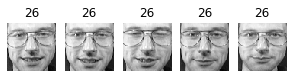

Cluster 10


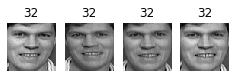

Cluster 11


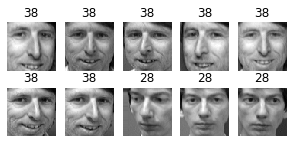

Cluster 12


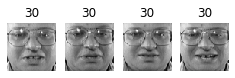

Cluster 13


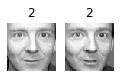

Cluster 14


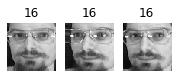

Cluster 15


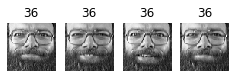

Cluster 16


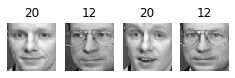

Cluster 17


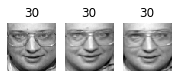

Cluster 18


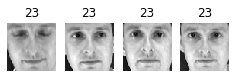

Cluster 19


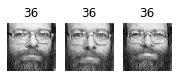

Cluster 20


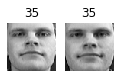

Cluster 21


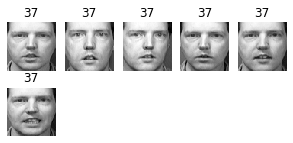

Cluster 22


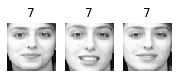

Cluster 23


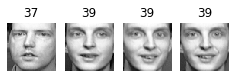

Cluster 24


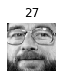

Cluster 25


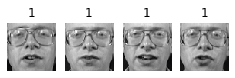

Cluster 26


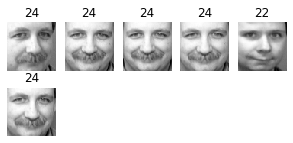

Cluster 27


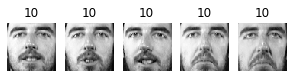

Cluster 28


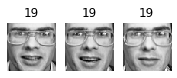

Cluster 29


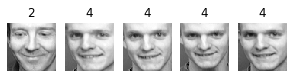

Cluster 30


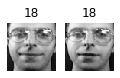

Cluster 31


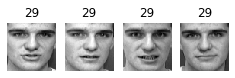

Cluster 32


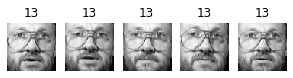

Cluster 33


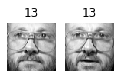

Cluster 34


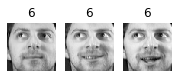

Cluster 35


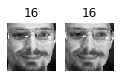

Cluster 36


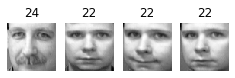

Cluster 37


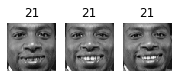

Cluster 38


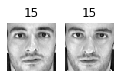

Cluster 39


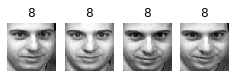

Cluster 40


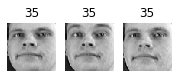

Cluster 41


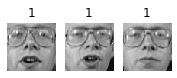

Cluster 42


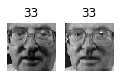

Cluster 43


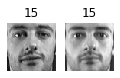

Cluster 44


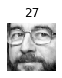

Cluster 45


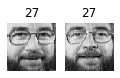

Cluster 46


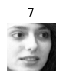

Cluster 47


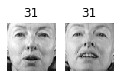

Cluster 48


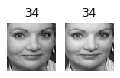

Cluster 49


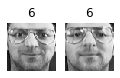

Cluster 50


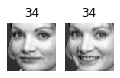

Cluster 51


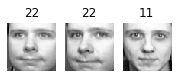

Cluster 52


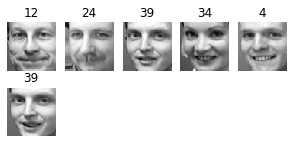

Cluster 53


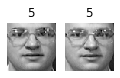

Cluster 54


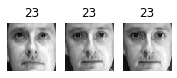

Cluster 55


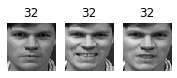

Cluster 56


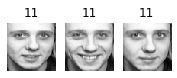

Cluster 57


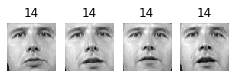

Cluster 58


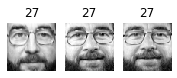

Cluster 59


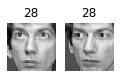

Cluster 60


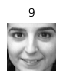

Cluster 61


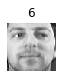

Cluster 62


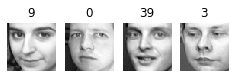

Cluster 63


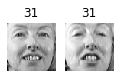

Cluster 64


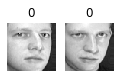

Cluster 65


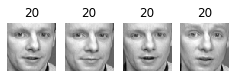

Cluster 66


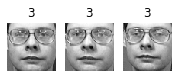

Cluster 67


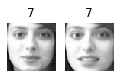

Cluster 68


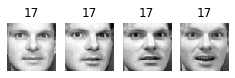

Cluster 69


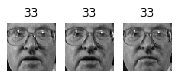

Cluster 70


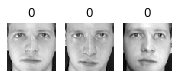

Cluster 71


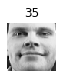

Cluster 72


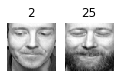

Cluster 73


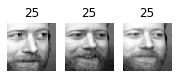

Cluster 74


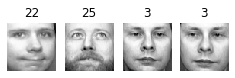

Cluster 75


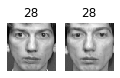

Cluster 76


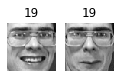

Cluster 77


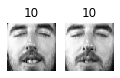

Cluster 78


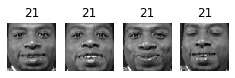

Cluster 79


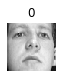

Cluster 80


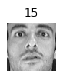

Cluster 81


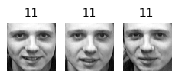

Cluster 82


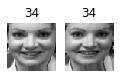

Cluster 83


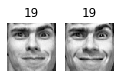

Cluster 84


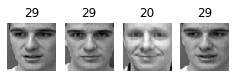

Cluster 85


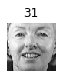

Cluster 86


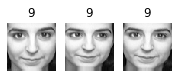

Cluster 87


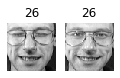

Cluster 88


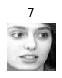

Cluster 89


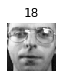

Cluster 90


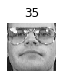

Cluster 91


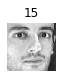

Cluster 92


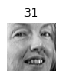

Cluster 93


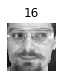

Cluster 94


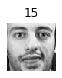

Cluster 95


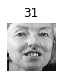

Cluster 96


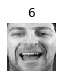

Cluster 97


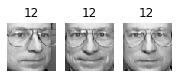

Cluster 98


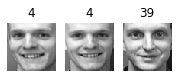

Cluster 99


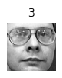

In [21]:
def plot_faces(faces, labels, n_cols = 5):
    n_rows = (len(faces)-1)// n_cols +1
    plt.figure(figsize = (n_cols,  n_rows *1.1))
    for index , (face,label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64,64), cmap = "gray")
        plt.axis("off")
        plt.title(label)
        
    plt.show()
    
for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_ == cluster_id
    faces = X_train[in_cluster].reshape(-1,64,64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

We can see the most of the clusters contain same persons sparring few. But, we can also see same persons are seperated into two different clusters.
This is tremendously useful when labelling images in a new dataset much faster.

## Clustering as Preprocessing for Classification

Training and evaluating classifier to predict which person is represented in each picture.

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 150, random_state = 42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9

Let's use K-Means as a dimensionality reduction tool.

In [23]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators = 150, random_state = 42)
clf.fit(X_train_reduced, y_train)

clf.score(X_valid_reduced,y_valid)

0.75

Nope!😫 That's not better. Let's see if tuning the number of clusters help.

In [25]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters= n_clusters, random_state = n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators = 150, random_state = 42))      
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3375
10 0.5375
15 0.5875
20 0.6625
25 0.65
30 0.7375
35 0.725
40 0.75
45 0.6875
50 0.7
55 0.725
60 0.775
65 0.7625
70 0.7
75 0.7625
80 0.725
85 0.7125
90 0.7125
95 0.75
100 0.75
105 0.7375
110 0.75
115 0.7375
120 0.7125
125 0.7625
130 0.7875
135 0.775
140 0.8
145 0.75


Even by tuning the number the clusters, we never got beyond 80% accuracy. May be distances to the cluster centroids are not as informative as original images.

How about appending these features to the original features?🧐

In [27]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]


In [28]:
clf = RandomForestClassifier(n_estimators = 150, random_state = 42)
clf.fit(X_train_extended, y_train)

clf.score(X_valid_extended, y_valid)

0.825

That's a bit better, but still worse than without clusters. Therefore, the clusters are not useful to directly train the classifier in this case.

## Gaussian Mixture Model for the Olivetti Faces Dataset

In [29]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 40, random_state = 42)
y_pred = gm.fit_predict(X_train_pca)

Let's generate some new faces from the GMM.

In [30]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples = n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

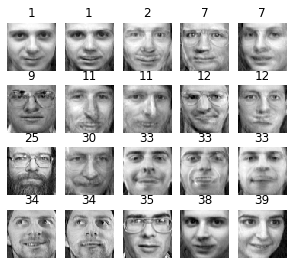

In [31]:
plot_faces(gen_faces, y_gen_faces)

Good! The most of the faces are looking real.

Let's play with these images, by rotating, flipping and darkening.

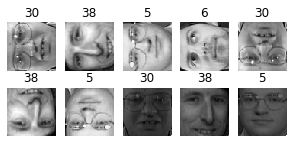

In [34]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1,64,64), axes = [0,2,1])
rotated = rotated.reshape(-1,64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1,64,64)[:,::-1]
flipped = flipped.reshape(-1,64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:,1:-1] *= 0.3
darkened = darkened.reshape(-1,64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)


In [35]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [36]:
gm.score_samples(X_bad_faces_pca)

array([-1.79997618e+07, -2.26427488e+07, -3.96415384e+07, -4.60254235e+07,
       -3.13975474e+07, -1.39330480e+07, -2.90882842e+07, -1.06298622e+08,
       -1.20931039e+08, -7.49740263e+07])

The bad faces are all considered highly unlikely by the GMM. Means it is correcly detecting the outliers.
Let's compare this to the scores of the traning instances.

In [37]:
gm.score_samples(X_train_pca[:10])

array([1163.02020934, 1149.16682422, 1148.47710551, 1170.67602846,
       1088.46009456, 1075.71700107, 1075.71700542, 1088.46008832,
       1096.42609683, 1119.68626971])

## PCA for Anomaly Detection

We already reduced the dataset using PCA earlier:

In [38]:
X_train_pca

array([[ 3.78081489e+00, -1.85479605e+00, -5.14404392e+00, ...,
        -1.35633051e-01, -2.14085609e-01,  6.11899309e-02],
       [ 1.01488562e+01, -1.52754700e+00, -7.66968191e-01, ...,
         1.23933010e-01, -1.35267794e-01, -2.32747681e-02],
       [-1.00152922e+01,  2.87728763e+00, -9.19884980e-01, ...,
         7.26133585e-02, -2.96397181e-03,  1.24893025e-01],
       ...,
       [ 2.47586966e+00,  2.95597172e+00,  1.29985571e+00, ...,
        -2.09107157e-02,  3.48529220e-02, -1.54323950e-01],
       [-3.22031665e+00,  5.34897995e+00,  1.39426756e+00, ...,
         5.75520471e-02, -2.28313312e-01,  1.55571416e-01],
       [-9.22876835e-01, -3.64702940e+00,  2.26088262e+00, ...,
         1.36851951e-01, -6.91312551e-02,  6.26852810e-02]], dtype=float32)

In [39]:
def reconstruction_errors(pca,X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis = -1)
    return mse

In [41]:
reconstruction_errors(pca, X_train).mean()

0.0001920535

In [42]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004707354

The reconstruction error for the bad faces is higher than training data. Resulting in the detection of Anomaly.

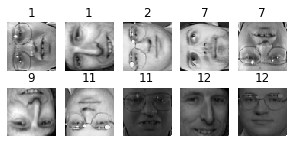

In [43]:
plot_faces(X_bad_faces, y_gen_faces)

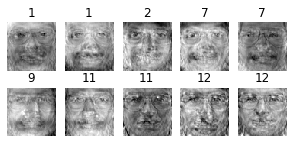

In [44]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed,y_gen_faces)

One can observe how bad the reconstructed images are.😬